In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

In [2]:
# To fix this error, you need to upload the 'diabetes.csv' file to your Colab environment.
# You can drag and drop the file into the 'Files' section on the left sidebar,
# or run the following code to upload it:
# from google.colab import files
# uploaded = files.upload()
# Then, update the path below to refer to the uploaded file.

# Original line causing error:
# diabetes = pd.read_csv("/Users/pranav_medikonduru/Downloads/diabetes.csv")

# Placeholder for the corrected path after uploading:
# For example, if you upload it directly to the Colab environment, it might be:
data_path = "diabetes.csv" # Or the correct path if it's in a subdirectory or mounted drive
diabetes = pd.read_csv(data_path)

print("Original shape:", diabetes.shape)
print(diabetes["Diabetes_012"].value_counts())

Original shape: (253680, 22)
Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


In [3]:
q1 = diabetes["BMI"].quantile(0.25)
q3 = diabetes["BMI"].quantile(0.75)
iqr = q3 - q1
upper_bmi = q3 + 1.5 * iqr

df = diabetes[diabetes["BMI"] < upper_bmi].copy()
print("After BMI filter:", df.shape)

After BMI filter: (243860, 22)


In [4]:
df["Diabetes_binary"] = df["Diabetes_012"].replace({0: 0, 1: 1, 2: 1})

In [5]:
df["BMI_cat"] = pd.cut(
    df["BMI"],
    bins=[0, 25, 30, 35, 1000],
    labels=[0, 1, 2, 3],
    include_lowest=True,
).astype(int)

df["Age_cat"] = pd.cut(
    df["Age"],
    bins=[0, 3, 7, 11, 20],
    labels=[0, 1, 2, 3],
    include_lowest=True,
).astype(int)

df["MetabolicRisk"] = df["HighBP"] + df["HighChol"]

df["LifestyleRisk"] = (
    df["Smoker"]
    + (1 - df["PhysActivity"])
    + df["HvyAlcoholConsump"]
    + (df["Fruits"] == 0).astype(int)
    + (df["Veggies"] == 0).astype(int)
)

df["HealthSeverity"] = df["GenHlth"] + df["MentHlth"] + df["PhysHlth"]

df["AccessIssues"] = (df["AnyHealthcare"] == 0).astype(int) + df["NoDocbcCost"]

df["Age2"] = df["Age"] ** 2
df["BMI2"] = df["BMI"] ** 2

df["BMI_Age"] = df["BMI"] * df["Age"]
df["BP_Chol"] = df["HighBP"] * df["HighChol"]

feature_cols = [
    "BMI", "HighBP", "HighChol", "CholCheck", "Smoker",
    "Stroke", "HeartDiseaseorAttack", "PhysActivity",
    "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare",
    "NoDocbcCost", "GenHlth", "MentHlth", "PhysHlth",
    "DiffWalk", "Sex", "Age", "Education", "Income",
    "BMI_cat", "Age_cat",
    "MetabolicRisk", "LifestyleRisk", "HealthSeverity", "AccessIssues",
    "Age2", "BMI2",
    "BMI_Age", "BP_Chol",
]

X = df[feature_cols]
y = df["Diabetes_binary"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train class counts:")
print(y_train.value_counts())
print("\nTest class counts:")
print(y_test.value_counts())

Train class counts:
Diabetes_binary
0.0    166030
1.0     29058
Name: count, dtype: int64

Test class counts:
Diabetes_binary
0.0    41508
1.0     7264
Name: count, dtype: int64


In [7]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("F1 (diabetes=1):", f1_score(y_true, y_pred, pos_label=1))
    print(classification_report(y_true, y_pred))

In [8]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        C=1.0,
        max_iter=1000,
        solver="lbfgs",
        class_weight="balanced"
    ))
])

model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [9]:
y_scores_train = model.predict_proba(X_train)[:, 1]
y_scores_test  = model.predict_proba(X_test)[:, 1]

In [10]:
y_pred_default = (y_scores_test >= 0.5).astype(int)
evaluate_model(
    "Logistic Regression (class_weight=balanced, threshold=0.5)",
    y_test,
    y_pred_default
)


=== Logistic Regression (class_weight=balanced, threshold=0.5) ===
Accuracy: 0.7296194537849586
Balanced accuracy: 0.7472826412847966
F1 (diabetes=1): 0.45974845343930515
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     41508
         1.0       0.33      0.77      0.46      7264

    accuracy                           0.73     48772
   macro avg       0.64      0.75      0.64     48772
weighted avg       0.86      0.73      0.77     48772



In [11]:
thresholds = np.linspace(0.1, 0.9, 81)
best_threshold = 0.5
best_f1 = -1
best_prec = None
best_rec = None

for t in thresholds:
    y_pred_t = (y_scores_test >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t, pos_label=1)
    if f1_t > best_f1:
        best_f1 = f1_t
        best_threshold = t
        best_prec = precision_score(y_test, y_pred_t, pos_label=1)
        best_rec = recall_score(y_test, y_pred_t, pos_label=1)

print(f"\nBest threshold by F1: {best_threshold:.3f}")
print(f"Precision@best: {best_prec:.3f}")
print(f"Recall@best:    {best_rec:.3f}")
print(f"F1@best:        {best_f1:.3f}")


Best threshold by F1: 0.600
Precision@best: 0.376
Recall@best:    0.656
F1@best:        0.478


In [12]:
y_pred_best = (y_scores_test >= best_threshold).astype(int)
evaluate_model(
    f"Logistic Regression (class_weight=balanced, threshold={best_threshold:.3f})",
    y_test,
    y_pred_best
)


=== Logistic Regression (class_weight=balanced, threshold=0.600) ===
Accuracy: 0.7863323218239974
Balanced accuracy: 0.7327303074955245
F1 (diabetes=1): 0.47782732875682715
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87     41508
         1.0       0.38      0.66      0.48      7264

    accuracy                           0.79     48772
   macro avg       0.65      0.73      0.67     48772
weighted avg       0.85      0.79      0.81     48772



<Figure size 600x500 with 0 Axes>

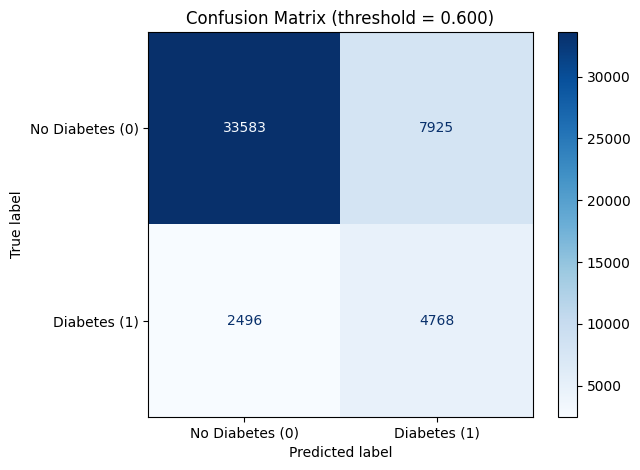

In [13]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes (0)", "Diabetes (1)"]
)
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (threshold = {best_threshold:.3f})")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


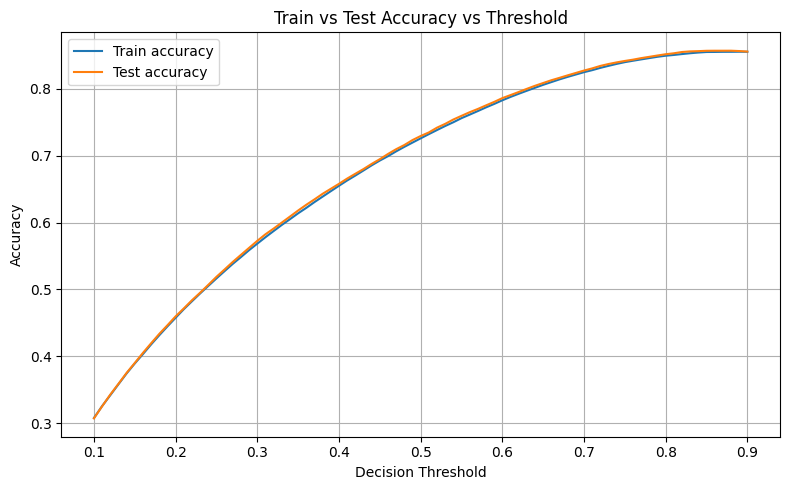

In [14]:
train_accs = []
test_accs = []

for t in thresholds:
    y_train_t = (y_scores_train >= t).astype(int)
    y_test_t  = (y_scores_test  >= t).astype(int)

    train_accs.append(accuracy_score(y_train, y_train_t))
    test_accs.append(accuracy_score(y_test, y_test_t))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, train_accs, label="Train accuracy")
plt.plot(thresholds, test_accs, label="Test accuracy")
plt.xlabel("Decision Threshold")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


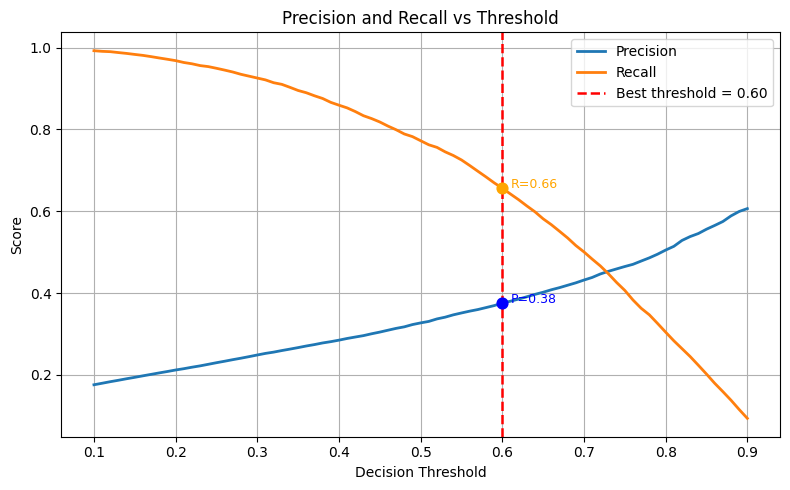

In [15]:
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_scores_test >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t, pos_label=1))
    recalls.append(recall_score(y_test, y_pred_t, pos_label=1))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, recalls, label="Recall", linewidth=2)


plt.axvline(best_threshold, color="red", linestyle="--", linewidth=1.8,
            label=f"Best threshold = {best_threshold:.2f}")

plt.scatter(best_threshold, best_prec, color="blue", s=60, zorder=5)
plt.scatter(best_threshold, best_rec, color="orange", s=60, zorder=5)

plt.text(best_threshold + 0.01, best_prec,
         f"P={best_prec:.2f}", color="blue", fontsize=9)
plt.text(best_threshold + 0.01, best_rec,
         f"R={best_rec:.2f}", color="orange", fontsize=9)


plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

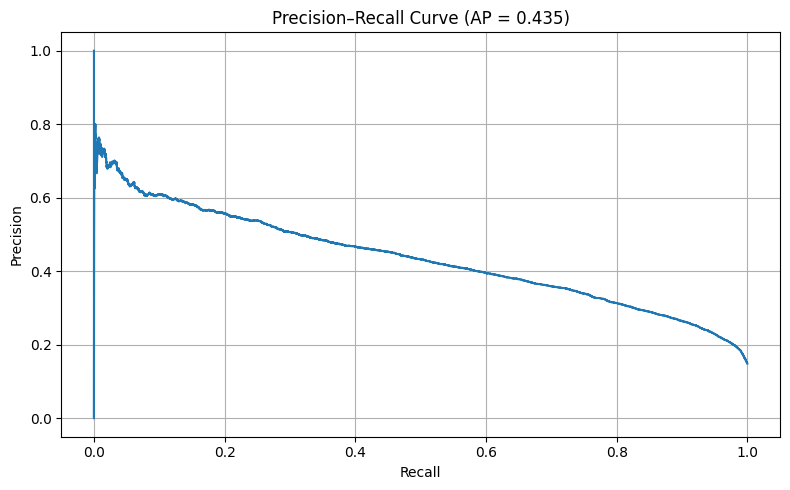

In [16]:
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_scores_test)
avg_prec = average_precision_score(y_test, y_scores_test)

plt.figure(figsize=(8, 5))
plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {avg_prec:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:

coefs = model["clf"].coef_[0]


coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": coefs,
    "Abs_Coefficient": np.abs(coefs)
})


coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

print(coef_df)

                 Feature  Coefficient  Abs_Coefficient
18                   Age     1.002588         1.002588
0                    BMI     0.707183         0.707183
27                  Age2    -0.617768         0.617768
13               GenHlth     0.579481         0.579481
28                  BMI2    -0.335699         0.335699
29               BMI_Age     0.234959         0.234959
3              CholCheck     0.233057         0.233057
23         MetabolicRisk     0.220532         0.220532
1                 HighBP     0.203401         0.203401
20                Income    -0.163993         0.163993
2               HighChol     0.152216         0.152216
10     HvyAlcoholConsump    -0.151486         0.151486
17                   Sex     0.124116         0.124116
22               Age_cat    -0.105958         0.105958
6   HeartDiseaseorAttack     0.069341         0.069341
15              PhysHlth    -0.058293         0.058293
30               BP_Chol    -0.036182         0.036182
19        

In [18]:
import joblib
joblib.dump(model, 'logReg_model.joblib')

['logReg_model.joblib']